In [13]:
#Import the librairies
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from mlxtend.plotting import plot_decision_regions
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt

import seaborn as sns

#Import the dataset
data = 'flight_data_2024_sample.csv'
flight_df = pd.read_csv(data)
print(flight_df.head())
print(flight_df.dtypes)

   year  month  day_of_month  day_of_week     fl_date op_unique_carrier  \
0  2024      4            18            4  2024-04-18                MQ   
1  2024      1             1            1  2024-01-01                AA   
2  2024     12            12            4  2024-12-12                9E   
3  2024      4             8            1  2024-04-08                WN   
4  2024      2            16            5  2024-02-16                WN   

   op_carrier_fl_num origin       origin_city_name origin_state_nm  ...  \
0             3535.0    DFW  Dallas/Fort Worth, TX           Texas  ...   
1              148.0    CLT          Charlotte, NC  North Carolina  ...   
2             5440.0    CHA        Chattanooga, TN       Tennessee  ...   
3             1971.0    OMA              Omaha, NE        Nebraska  ...   
4              862.0    BWI          Baltimore, MD        Maryland  ...   

  diverted crs_elapsed_time actual_elapsed_time  air_time  distance  \
0        0            151.0

## Clean the Dataset

### Remove none important independent variables

In [2]:
print(flight_df.columns)

flight_df.drop(['taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'arr_delay',
    'cancellation_code', 'diverted', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'], axis=1, inplace=True)
print(flight_df.columns)

Index(['year', 'month', 'day_of_month', 'day_of_week', 'fl_date',
       'op_unique_carrier', 'op_carrier_fl_num', 'origin', 'origin_city_name',
       'origin_state_nm', 'dest', 'dest_city_name', 'dest_state_nm',
       'crs_dep_time', 'dep_time', 'dep_delay', 'taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'arr_delay',
       'cancelled', 'cancellation_code', 'diverted', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'distance', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'],
      dtype='object')
Index(['year', 'month', 'day_of_month', 'day_of_week', 'fl_date',
       'op_unique_carrier', 'op_carrier_fl_num', 'origin', 'origin_city_name',
       'origin_state_nm', 'dest', 'dest_city_name', 'dest_state_nm',
       'crs_dep_time', 'dep_time', 'dep_delay', 'cancelled', 'distance'],
      dtype='object')


### Remove cancelled flights

In [3]:
flight_df = flight_df[flight_df['cancelled'] == 0]

print(flight_df)

      year  month  day_of_month  day_of_week     fl_date op_unique_carrier  \
0     2024      4            18            4  2024-04-18                MQ   
1     2024      1             1            1  2024-01-01                AA   
2     2024     12            12            4  2024-12-12                9E   
3     2024      4             8            1  2024-04-08                WN   
4     2024      2            16            5  2024-02-16                WN   
...    ...    ...           ...          ...         ...               ...   
9995  2024      1            16            2  2024-01-16                WN   
9996  2024      7             5            5  2024-07-05                AA   
9997  2024      2            28            3  2024-02-28                MQ   
9998  2024      2            18            7  2024-02-18                DL   
9999  2024      3             1            5  2024-03-01                G4   

      op_carrier_fl_num origin       origin_city_name origin_st

## Create new categories

In [16]:
flight_df['flight_delayed'] = (flight_df['dep_delay'] > 0).astype(int)
print(flight_df.head())

   year  month  day_of_month  day_of_week     fl_date op_unique_carrier  \
0  2024      4            18            4  2024-04-18                MQ   
1  2024      1             1            1  2024-01-01                AA   
2  2024     12            12            4  2024-12-12                9E   
3  2024      4             8            1  2024-04-08                WN   
4  2024      2            16            5  2024-02-16                WN   

   op_carrier_fl_num origin       origin_city_name origin_state_nm  ...  \
0             3535.0    DFW  Dallas/Fort Worth, TX           Texas  ...   
1              148.0    CLT          Charlotte, NC  North Carolina  ...   
2             5440.0    CHA        Chattanooga, TN       Tennessee  ...   
3             1971.0    OMA              Omaha, NE        Nebraska  ...   
4              862.0    BWI          Baltimore, MD        Maryland  ...   

  crs_elapsed_time actual_elapsed_time air_time  distance  carrier_delay  \
0            151.0    

## Visualisation

### Bar Charts

#### Delays by Carriers

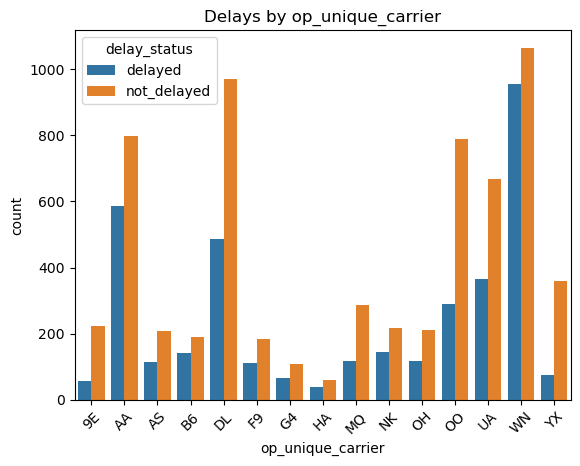

In [25]:
# Group by carrier and calculate delays
group_col = 'op_unique_carrier'
delay_by_group = flight_df.groupby(group_col).agg(
    delayed=('flight_delayed', 'sum'),
    not_delayed=('flight_delayed', 'size')
).reset_index()
delay_by_group['not_delayed'] = delay_by_group['not_delayed'] - delay_by_group['delayed']

# Melt and plot
delay_melted_group = delay_by_group.melt(id_vars=group_col, var_name='delay_status', value_name='count')
sns.barplot(x=group_col, y='count', hue='delay_status', data=delay_melted_group)
plt.title(f'Delays by {group_col}')
plt.xticks(rotation=45)
plt.show()

#### Delays by Origin

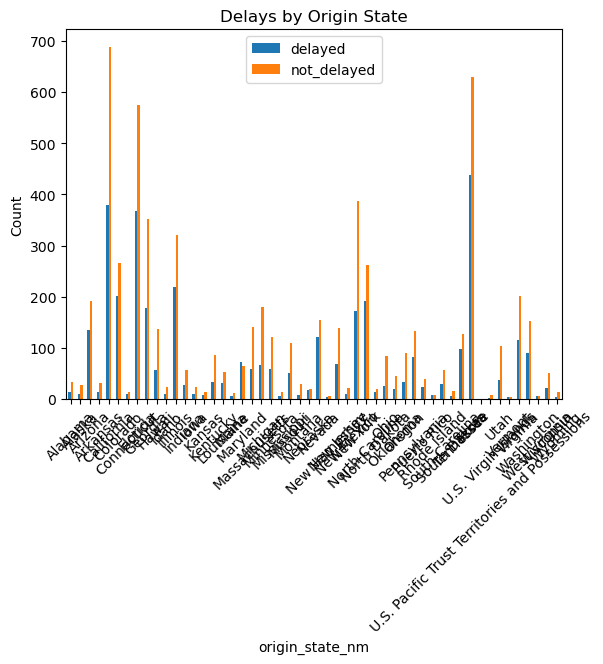

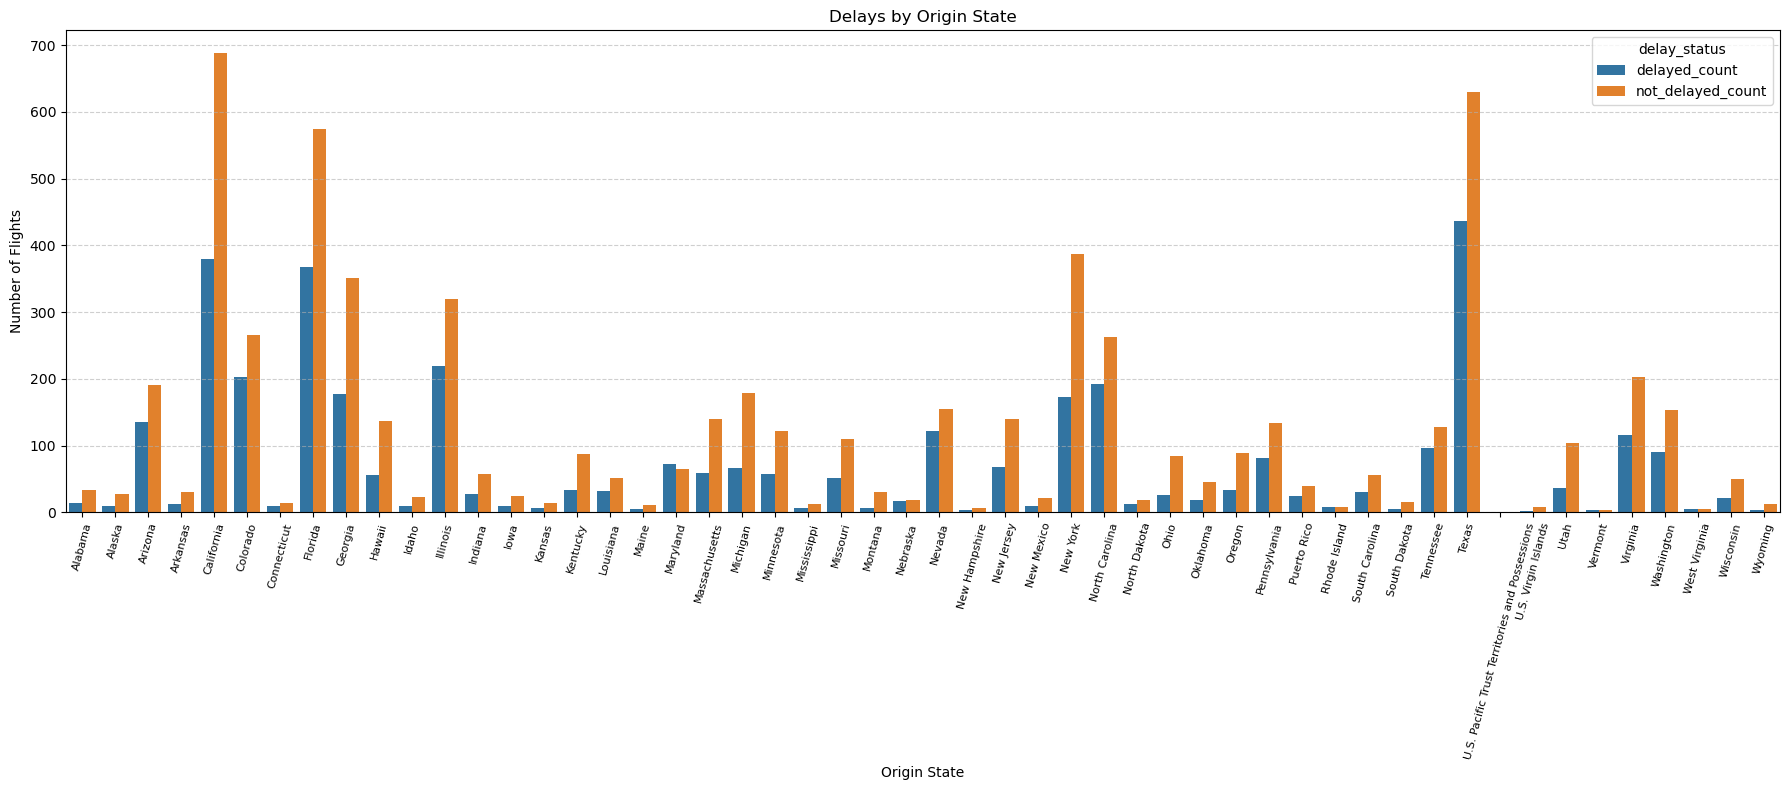

In [24]:
# Group by origin and calculate delays
delay_by_state = flight_df.groupby('origin_state_nm').agg(
    delayed=('flight_delayed', 'sum'),
    not_delayed=('flight_delayed', 'size')
).reset_index()
delay_by_state['not_delayed'] = delay_by_state['not_delayed'] - delay_by_state['delayed']
# Plot directly
delay_by_state.set_index('origin_state_nm')[['delayed', 'not_delayed']].plot(kind='bar')
plt.title('Delays by Origin State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# More readable version with formatting and help of AI
delay_by_state = flight_df.groupby('origin_state_nm')['flight_delayed'].sum().reset_index()
delay_by_state.columns = ['origin_state_nm', 'delayed_count']
delay_by_state['not_delayed_count'] = flight_df.groupby('origin_state_nm').size().values - delay_by_state['delayed_count']
delay_melted = delay_by_state.melt(id_vars='origin_state_nm', var_name='delay_status', value_name='count')
# Sort states alphabetically
state_order = delay_by_state.sort_values('origin_state_nm')['origin_state_nm']
plt.figure(figsize=(18,8))
sns.barplot(x='origin_state_nm', y='count', hue='delay_status', data=delay_melted, order=state_order)
plt.title('Delays by Origin State')
plt.xticks(rotation=75, fontsize=8)
plt.xlabel('Origin State')
plt.ylabel('Number of Flights')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### Delays by Destinations

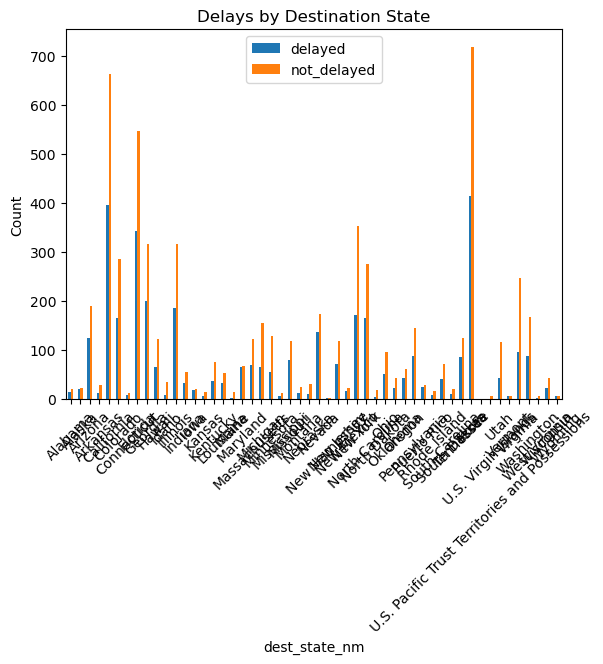

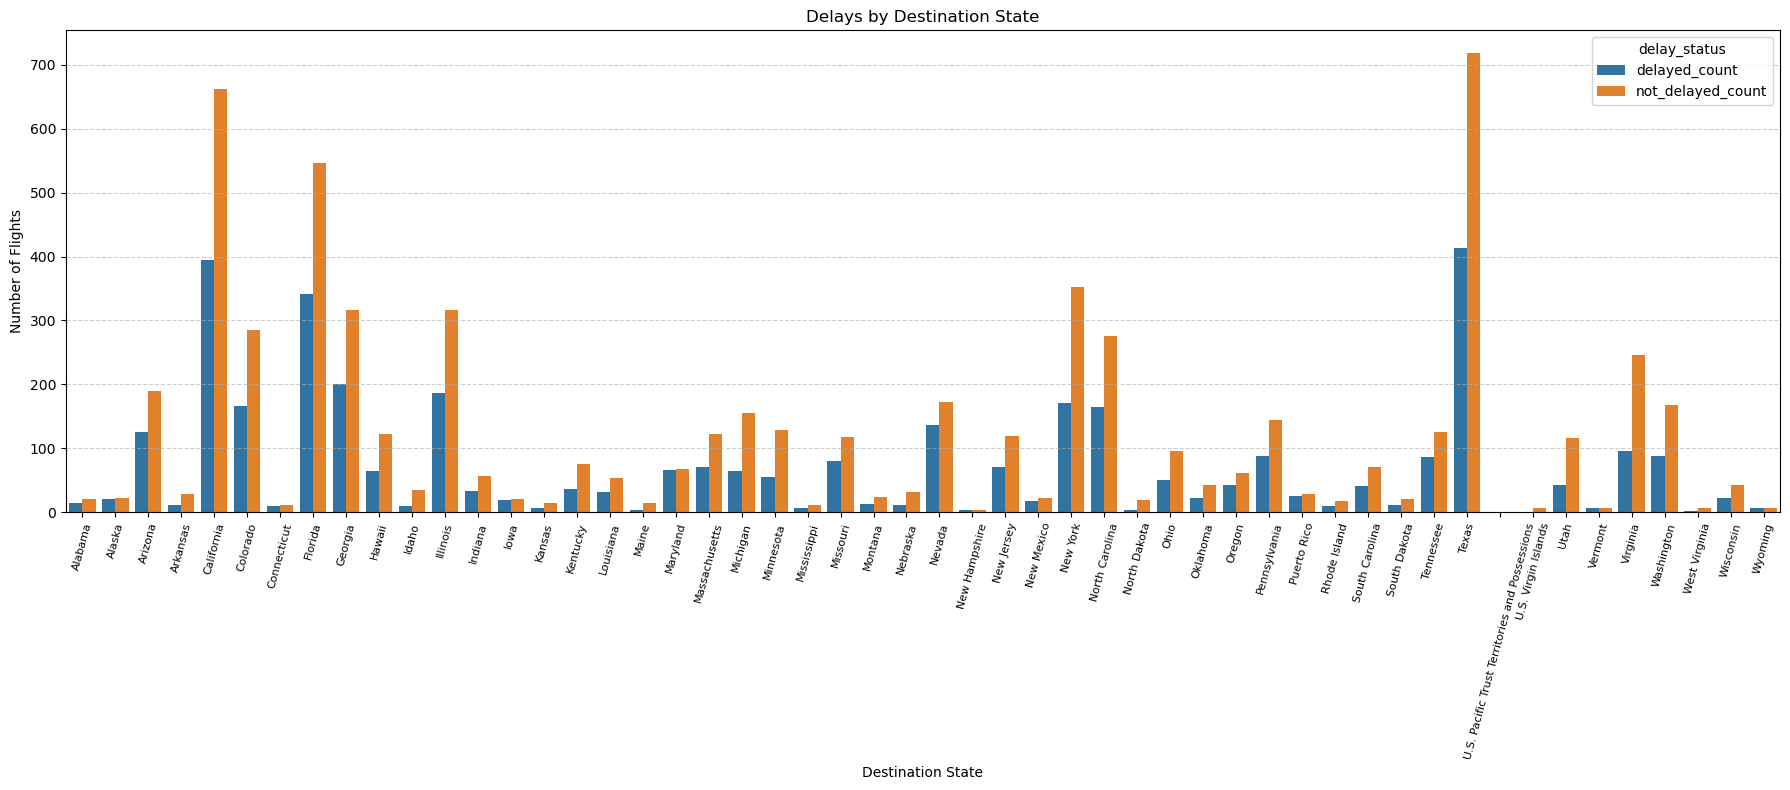

In [23]:
# Group by destination and calculate delays
delay_by_state = flight_df.groupby('dest_state_nm').agg(
    delayed=('flight_delayed', 'sum'),
    not_delayed=('flight_delayed', 'size')
).reset_index()

delay_by_state['not_delayed'] = delay_by_state['not_delayed'] - delay_by_state['delayed']

# Plot directly
delay_by_state.set_index('dest_state_nm')[['delayed', 'not_delayed']].plot(kind='bar')
plt.title('Delays by Destination State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# More readable version with formatting and help of AI
delay_by_state = flight_df.groupby('dest_state_nm')['flight_delayed'].sum().reset_index()
delay_by_state.columns = ['dest_state_nm', 'delayed_count']
delay_by_state['not_delayed_count'] = flight_df.groupby('dest_state_nm').size().values - delay_by_state['delayed_count']

delay_melted = delay_by_state.melt(id_vars='dest_state_nm', var_name='delay_status', value_name='count')

# Sort states alphabetically
state_order = delay_by_state.sort_values('dest_state_nm')['dest_state_nm']

plt.figure(figsize=(18,8))
sns.barplot(x='dest_state_nm', y='count', hue='delay_status', data=delay_melted, order=state_order)
plt.title('Delays by Destination State')
plt.xticks(rotation=75, fontsize=8)
plt.xlabel('Destination State')
plt.ylabel('Number of Flights')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### Delays by Months

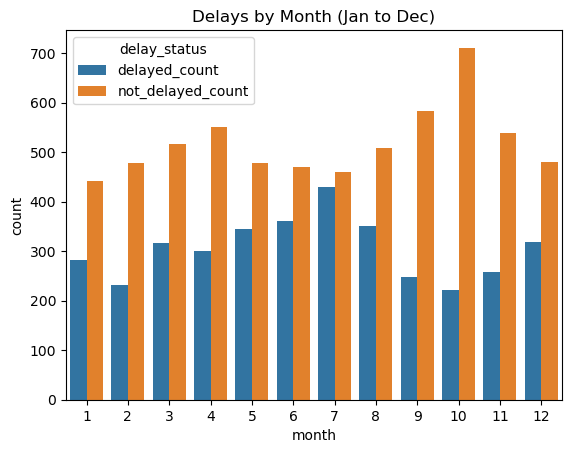

In [12]:
# Aggregate delayed vs not delayed by month
delay_by_month = flight_df.groupby('month')['flight_delayed'].sum().reset_index()
delay_by_month.columns = ['month', 'delayed_count']

# Calculate not delayed count
delay_by_month['not_delayed_count'] = flight_df.groupby('month').size().values - delay_by_month['delayed_count']

# Melt to long-form for seaborn
delay_melted = delay_by_month.melt(id_vars='month', var_name='delay_status', value_name='count')

sns.barplot(x='month', y='count', hue='delay_status', data=delay_melted)
plt.title('Delays by Month (Jan to Dec)')
plt.show()

#### Delays by Day of the Week

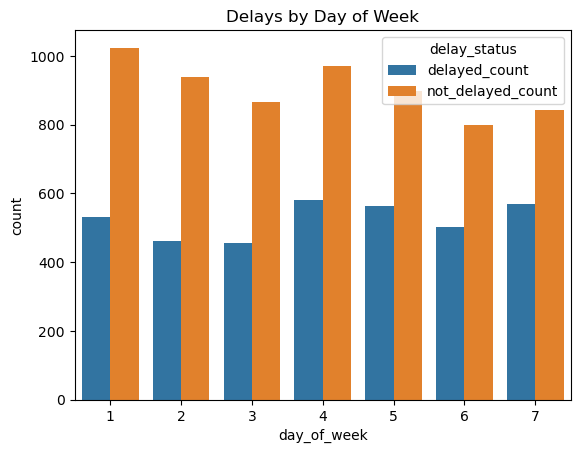

In [17]:
# Group by day_of_week, sum delay counts
delay_by_day = flight_df.groupby('day_of_week')['flight_delayed'].sum().reset_index()
delay_by_day.columns = ['day_of_week', 'delayed_count']

# Calculate not delayed count
delay_by_day['not_delayed_count'] = flight_df.groupby('day_of_week').size().values - delay_by_day['delayed_count']

# Melt to long format for seaborn
delay_melted_day = delay_by_day.melt(id_vars='day_of_week', var_name='delay_status', value_name='count')

sns.barplot(x='day_of_week', y='count', hue='delay_status', data=delay_melted_day)
plt.title('Delays by Day of Week')
plt.show()

### Scatterplots


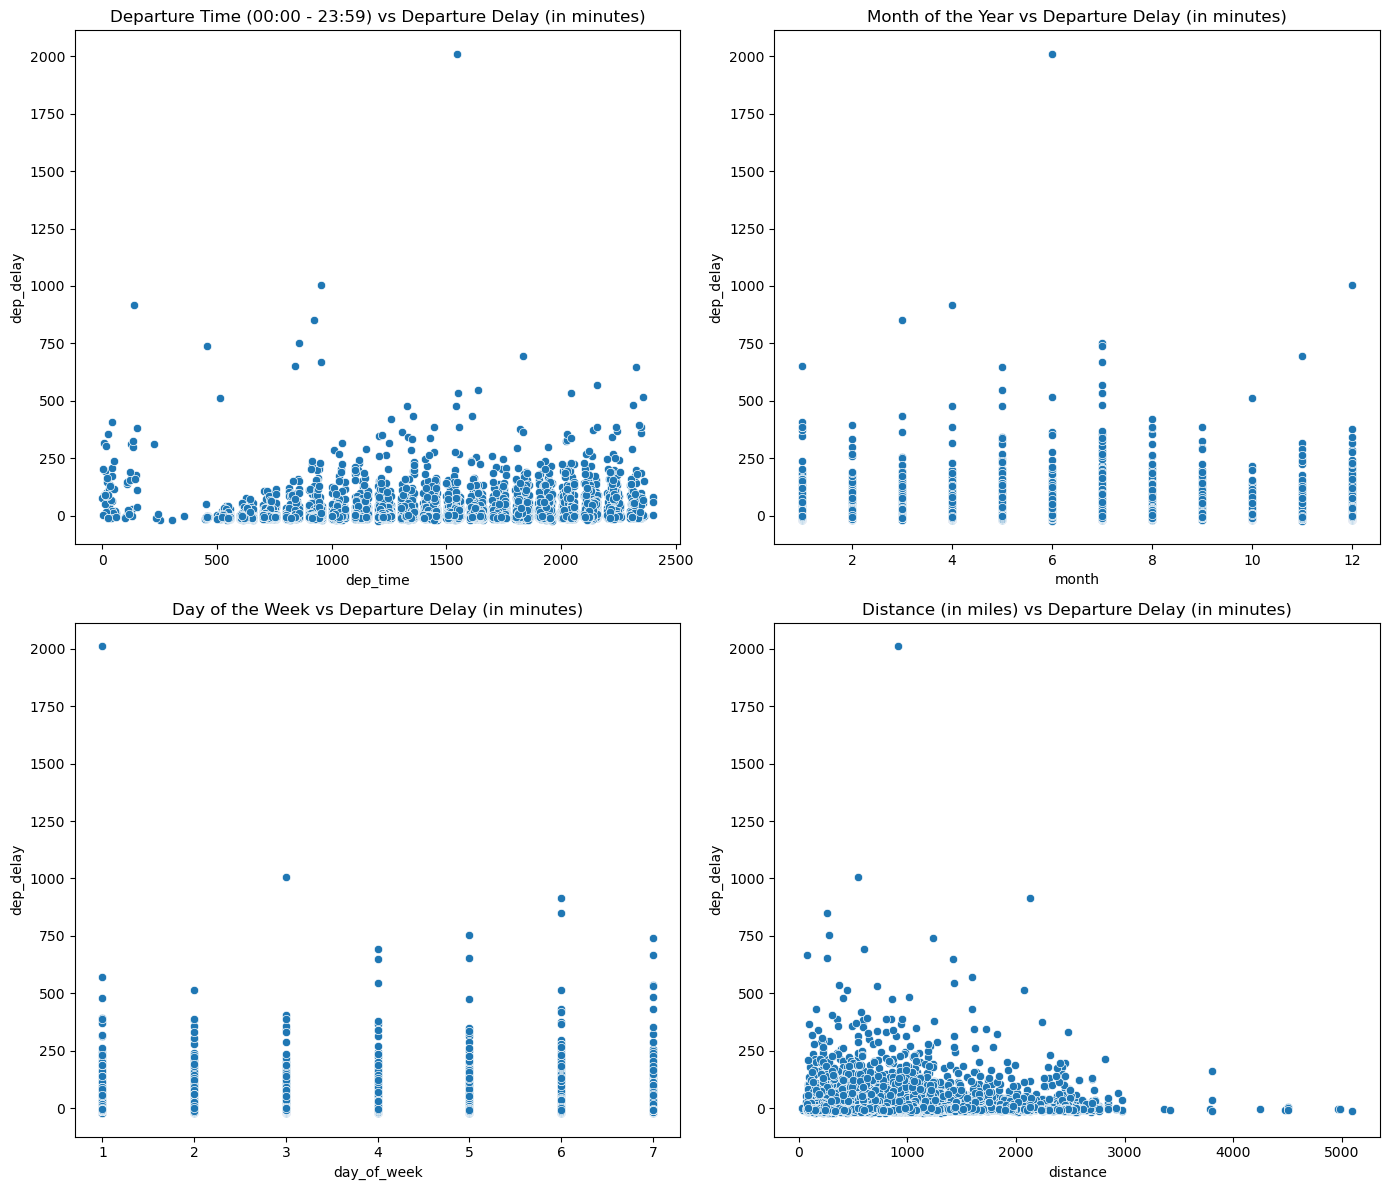

In [5]:
# Prepare a 2x2 grid of scatterplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# dep_time vs dep_delay
sns.scatterplot(data=flight_df, x='dep_time', y='dep_delay', ax=axes[0,0])
axes[0,0].set_title('Departure Time (00:00 - 23:59) vs Departure Delay (in minutes)')

# month vs dep_delay
sns.scatterplot(data=flight_df, x='month', y='dep_delay', ax=axes[0,1])
axes[0,1].set_title('Month of the Year vs Departure Delay (in minutes)')

# day_of_week vs dep_delay
sns.scatterplot(data=flight_df, x='day_of_week', y='dep_delay', ax=axes[1,0])
axes[1,0].set_title('Day of the Week vs Departure Delay (in minutes)')

# distance vs dep_delay
sns.scatterplot(data=flight_df, x='distance', y='dep_delay', ax=axes[1,1])
axes[1,1].set_title('Distance (in miles) vs Departure Delay (in minutes)')

plt.tight_layout()
plt.show()

### Correlation Matrix - Heatmap

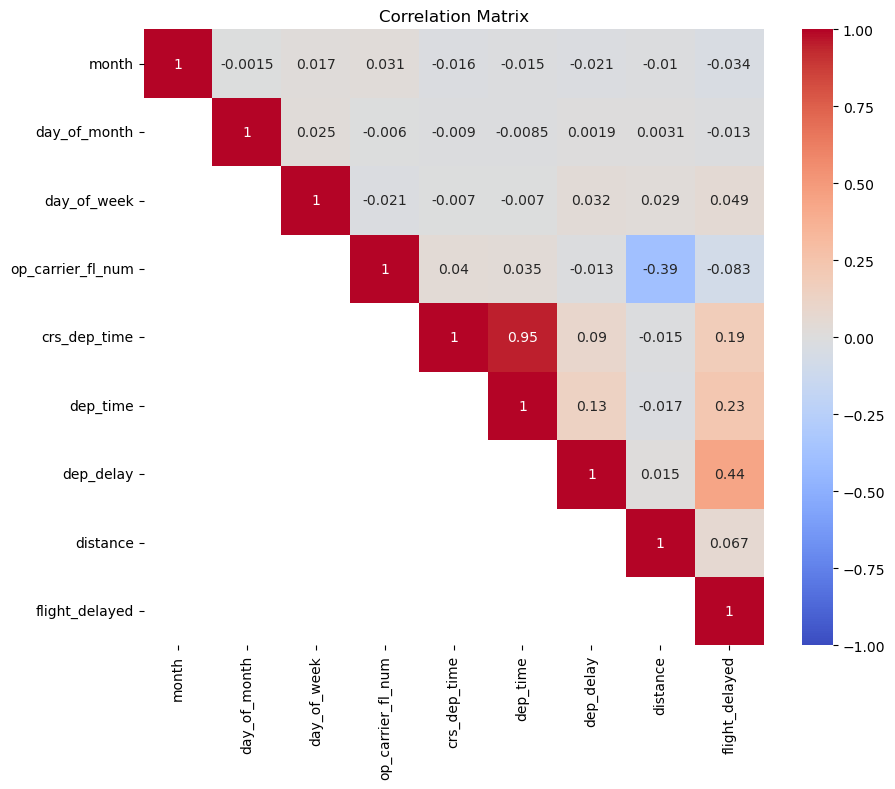

In [6]:
# Select only needed variables
numeric_df = flight_df.drop(columns=['fl_date','cancelled','year']).select_dtypes(include='number')
corr_matrix = numeric_df.corr()

mask = np.tril(np.ones_like(corr_matrix, dtype=bool), k=-1)
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask)
plt.title('Correlation Matrix')
plt.show()